In [1]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [2]:
data = pd.read_csv("marketing_campaign.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


ID  Year_Birth   Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957  Graduation         Single  58138.0        0         0   
1  2174        1954  Graduation         Single  46344.0        1         1   
2  4141        1965  Graduation       Together  71613.0        0         0   
3  6182        1984  Graduation       Together  26646.0        1         0   
4  5324        1981         PhD        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  NumWebVisitsMonth  AcceptedCmp3  \
0  04-09-2012       58       635  ...                  7             0   
1  08-03-2014       38        11  ...                  5             0   
2  21-08-2013       26       426  ...                  4             0   
3  10-02-2014       26        11  ...                  6             0   
4  19-01-2014       94       173  ...                  5             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  \
0             0             0             0             0         0   
1             0             0             0             0         0   
2             0             0             0             0         0   
3             0             0             0             0         0   
4             0             0             0             0         0   

   Z_CostContact  Z_Revenue  Response  
0              3         11         1  
1              3         11         0  
2              3         11         0  
3              3         11         0  
4              3         11         0  

[5 rows x 29 columns]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [4]:
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In [5]:
data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"],format='%d-%m-%Y')
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)  
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [6]:
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [7]:
print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In [8]:
#Feature Engineering
#Age of customer today 
data["Age"] = 2021-data["Year_Birth"]
#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

#Dropping some of the redundant features
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(to_drop, axis=1)

In [9]:
data.describe()

Income      Kidhome     Teenhome      Recency        Wines  \
count    2216.000000  2216.000000  2216.000000  2216.000000  2216.000000   
mean    52247.251354     0.441787     0.505415    49.012635   305.091606   
std     25173.076661     0.536896     0.544181    28.948352   337.327920   
min      1730.000000     0.000000     0.000000     0.000000     0.000000   
25%     35303.000000     0.000000     0.000000    24.000000    24.000000   
50%     51381.500000     0.000000     0.000000    49.000000   174.500000   
75%     68522.000000     1.000000     1.000000    74.000000   505.000000   
max    666666.000000     2.000000     2.000000    99.000000  1493.000000   

            Fruits         Meat         Fish       Sweets         Gold  ...  \
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  ...   
mean     26.356047   166.995939    37.637635    27.028881    43.965253  ...   
std      39.793917   224.283273    54.752082    41.072046    51.815414  ...   
min       0.000000     0.000000     0.000000     0.000000     0.000000  ...   
25%       2.000000    16.000000     3.000000     1.000000     9.000000  ...   
50%       8.000000    68.000000    12.000000     8.000000    24.500000  ...   
75%      33.000000   232.250000    50.000000    33.000000    56.000000  ...   
max     199.000000  1725.000000   259.000000   262.000000   321.000000  ...   

       AcceptedCmp1  AcceptedCmp2     Complain     Response  Customer_For  \
count   2216.000000   2216.000000  2216.000000  2216.000000  2.216000e+03   
mean       0.064079      0.013538     0.009477     0.150271  3.054423e+16   
std        0.244950      0.115588     0.096907     0.357417  1.749036e+16   
min        0.000000      0.000000     0.000000     0.000000  0.000000e+00   
25%        0.000000      0.000000     0.000000     0.000000  1.555200e+16   
50%        0.000000      0.000000     0.000000     0.000000  3.071520e+16   
75%        0.000000      0.000000     0.000000     0.000000  4.570560e+16   
max        1.000000      1.000000     1.000000     1.000000  6.039360e+16   

               Age        Spent     Children  Family_Size    Is_Parent  
count  2216.000000  2216.000000  2216.000000  2216.000000  2216.000000  
mean     52.179603   607.075361     0.947202     2.592509     0.714350  
std      11.985554   602.900476     0.749062     0.905722     0.451825  
min      25.000000     5.000000     0.000000     1.000000     0.000000  
25%      44.000000    69.000000     0.000000     2.000000     0.000000  
50%      51.000000   396.500000     1.000000     3.000000     1.000000  
75%      62.000000  1048.000000     1.000000     3.000000     1.000000  
max     128.000000  2525.000000     3.000000     5.000000     1.000000  

[8 rows x 28 columns]

Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

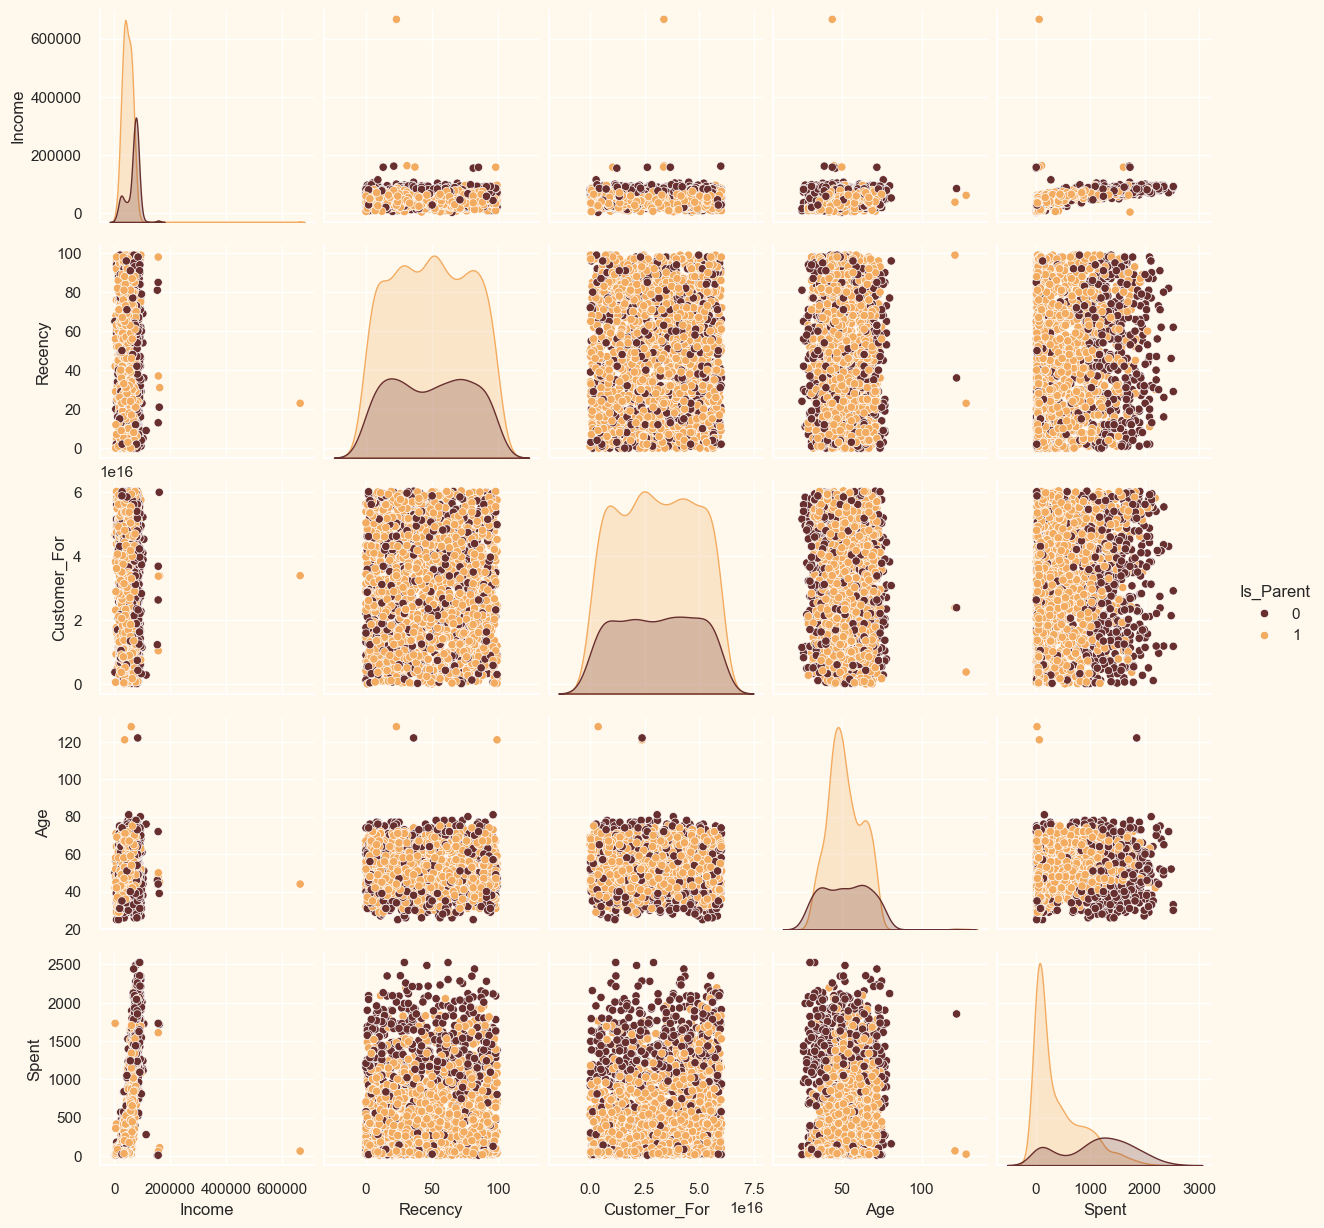

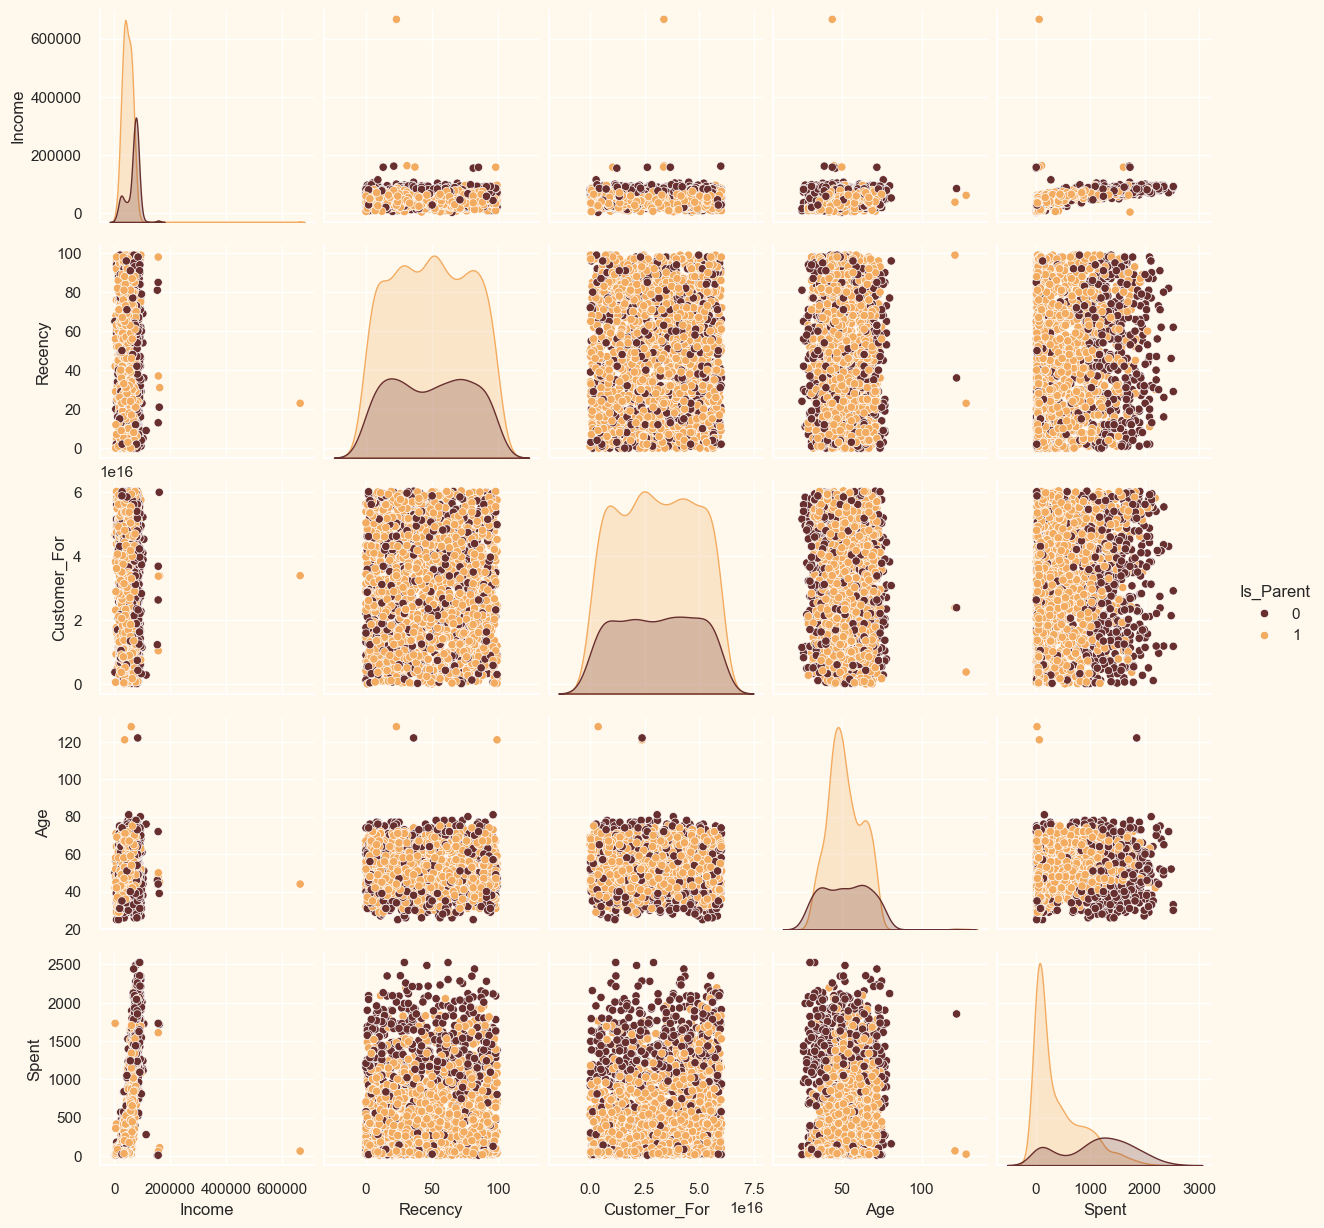

In [10]:
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue 
plt.show()
# Create a pairplot
pairplot = sns.pairplot(data[To_Plot], hue="Is_Parent", palette=["#682F2F","#F3AB60"])
# Save the plot to a file
pairplot.savefig("pairplot.png", dpi=300, bbox_inches='tight')


In [11]:
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


In [12]:
corrmat= data.corr(numeric_only=True)
corrmat

Income   Kidhome  Teenhome   Recency     Wines  \
Income               1.000000 -0.514523  0.034565  0.007965  0.688209   
Kidhome             -0.514523  1.000000 -0.039066  0.010623 -0.497203   
Teenhome             0.034565 -0.039066  1.000000  0.014392  0.003945   
Recency              0.007965  0.010623  0.014392  1.000000  0.015981   
Wines                0.688209 -0.497203  0.003945  0.015981  1.000000   
Fruits               0.507354 -0.373258 -0.175905 -0.005257  0.385844   
Meat                 0.692279 -0.439031 -0.261134  0.022914  0.568081   
Fish                 0.520040 -0.388643 -0.205235  0.000788  0.396915   
Sweets               0.523599 -0.377843 -0.163107  0.025244  0.389583   
Gold                 0.388299 -0.354922 -0.018579  0.018148  0.391461   
NumDealsPurchases   -0.108207  0.216594  0.386805  0.002591  0.009117   
NumWebPurchases      0.459265 -0.372327  0.162239 -0.005680  0.553663   
NumCatalogPurchases  0.696589 -0.504598 -0.112477  0.024197  0.634237   
NumStorePurchases    0.631424 -0.501863  0.049212 -0.000460  0.640219   
NumWebVisitsMonth   -0.650257  0.447258  0.130985 -0.018965 -0.321616   
AcceptedCmp3        -0.015152  0.016135 -0.042797 -0.032361  0.061360   
AcceptedCmp4         0.219633 -0.162111  0.038168  0.017520  0.373349   
AcceptedCmp5         0.395569 -0.204582 -0.190119  0.000233  0.472889   
AcceptedCmp1         0.327524 -0.174261 -0.145198 -0.021147  0.351610   
AcceptedCmp2         0.104036 -0.081911 -0.015633 -0.001429  0.206309   
Complain            -0.027900  0.037067  0.007746  0.005713 -0.036420   
Response             0.161387 -0.077901 -0.154402 -0.200114  0.246320   
Customer_For        -0.023760 -0.055281  0.018557  0.025681  0.167852   
Age                  0.199977 -0.237497  0.361932  0.015694  0.164615   
Spent                0.792740 -0.557949 -0.137964  0.020479  0.892996   
Children            -0.343529  0.688081  0.698199  0.018062 -0.353356   
Family_Size         -0.286638  0.583250  0.594481  0.014717 -0.296702   
Is_Parent           -0.403132  0.520355  0.587993  0.002189 -0.341994   

                       Fruits      Meat      Fish    Sweets      Gold  ...  \
Income               0.507354  0.692279  0.520040  0.523599  0.388299  ...   
Kidhome             -0.373258 -0.439031 -0.388643 -0.377843 -0.354922  ...   
Teenhome            -0.175905 -0.261134 -0.205235 -0.163107 -0.018579  ...   
Recency             -0.005257  0.022914  0.000788  0.025244  0.018148  ...   
Wines                0.385844  0.568081  0.396915  0.389583  0.391461  ...   
Fruits               1.000000  0.546740  0.593038  0.571474  0.393459  ...   
Meat                 0.546740  1.000000  0.572986  0.534624  0.357556  ...   
Fish                 0.593038  0.572986  1.000000  0.583484  0.426299  ...   
Sweets               0.571474  0.534624  0.583484  1.000000  0.356754  ...   
Gold                 0.393459  0.357556  0.426299  0.356754  1.000000  ...   
NumDealsPurchases   -0.134191 -0.121128 -0.143147 -0.121395  0.053047  ...   
NumWebPurchases      0.302301  0.306841  0.299428  0.333608  0.407873  ...   
NumCatalogPurchases  0.485611  0.733787  0.532241  0.494623  0.441656  ...   
NumStorePurchases    0.459875  0.486349  0.457885  0.455150  0.390693  ...   
NumWebVisitsMonth   -0.417741 -0.539194 -0.446151 -0.422289 -0.245973  ...   
AcceptedCmp3         0.014644  0.018416 -0.000276  0.001660  0.125557  ...   
AcceptedCmp4         0.006598  0.091677  0.016058  0.029206  0.024305  ...   
AcceptedCmp5         0.208990  0.375252  0.194793  0.258417  0.176628  ...   
AcceptedCmp1         0.192417  0.313379  0.261712  0.245113  0.170853  ...   
AcceptedCmp2        -0.009924  0.043549  0.002322  0.010142  0.050976  ...   
Complain            -0.002956 -0.021017 -0.019098 -0.020569 -0.030166  ...   
Response             0.123007  0.237966  0.108135  0.116059  0.141096  ...   
Customer_For         0.068137  0.089462  0.081700  0.080727  0.161115  ...   
Age                  0.013447  0.

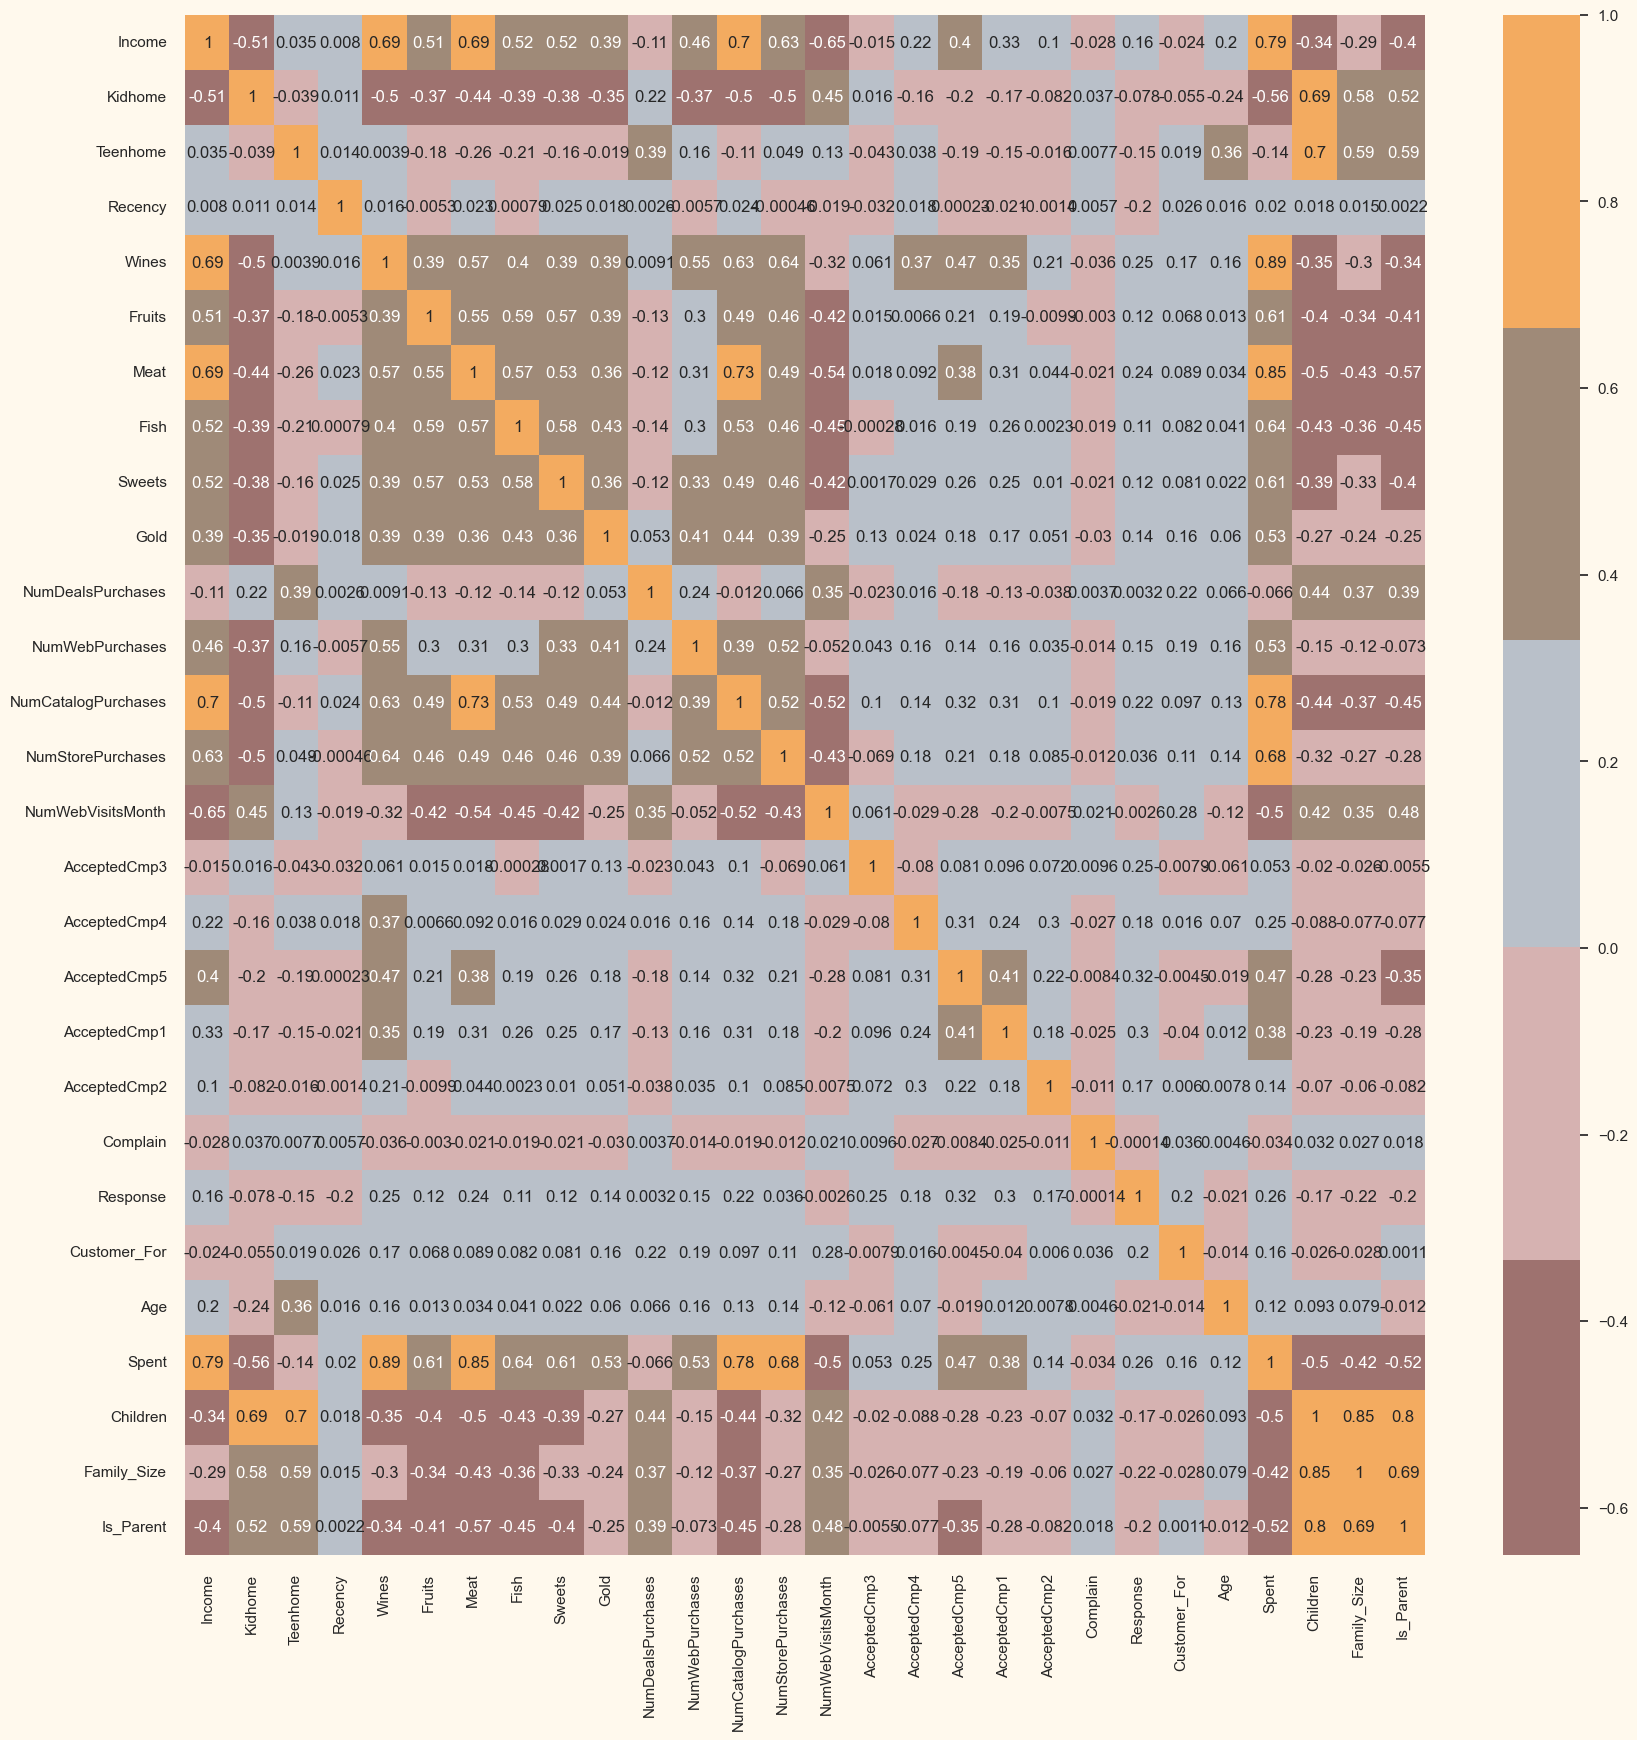

In [13]:
plt.figure(figsize=(20,20))  
sns.heatmap(corrmat,annot=True, cmap=cmap, center=0)
# Save the heatmap to a file
plt.savefig("heatmap.png", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [15]:
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [16]:
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [17]:
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


Education    Income   Kidhome  Teenhome   Recency     Wines    Fruits  \
0  -0.893586  0.287105 -0.822754 -0.929699  0.310353  0.977660  1.552041   
1  -0.893586 -0.260882  1.040021  0.908097 -0.380813 -0.872618 -0.637461   
2  -0.893586  0.913196 -0.822754 -0.929699 -0.795514  0.357935  0.570540   
3  -0.893586 -1.176114  1.040021 -0.929699 -0.795514 -0.872618 -0.561961   
4   0.571657  0.294307  1.040021 -0.929699  1.554453 -0.392257  0.419540   

       Meat      Fish    Sweets  ...  NumCatalogPurchases  NumStorePurchases  \
0  1.690293  2.453472  1.483713  ...             2.503607          -0.555814   
1 -0.718230 -0.651004 -0.634019  ...            -0.571340          -1.171160   
2 -0.178542  1.339513 -0.147184  ...            -0.229679           1.290224   
3 -0.655787 -0.504911 -0.585335  ...            -0.913000          -0.555814   
4 -0.218684  0.152508 -0.001133  ...             0.111982           0.059532   

   NumWebVisitsMonth  Customer_For       Age     Spent  Living_With  Children  \
0           0.692181      1.527721  1.018352  1.676245    -1.349603 -1.264598   
1          -0.132545     -1.189011  1.274785 -0.963297    -1.349603  1.404572   
2          -0.544908     -0.206048  0.334530  0.280110     0.740959 -1.264598   
3           0.279818     -1.060584 -1.289547 -0.920135     0.740959  0.069987   
4          -0.132545     -0.951915 -1.033114 -0.307562     0.740959  0.069987   

   Family_Size  Is_Parent  
0    -1.758359  -1.581139  
1     0.449070   0.632456  
2    -0.654644  -1.581139  
3     0.449070   0.632456  
4     0.449070   0.632456  

[5 rows x 23 columns]

In [18]:
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

count          mean       std       min       25%       50%       75%  \
col1  2212.0  5.781993e-17  2.878602 -5.978123 -2.539470 -0.781595  2.386380   
col2  2212.0  3.212219e-17  1.709469 -4.194757 -1.323932 -0.173716  1.234923   
col3  2212.0  7.468408e-17  1.231685 -3.625184 -0.853556 -0.051292  0.863841   

           max  
col1  7.452915  
col2  6.168185  
col3  6.746845

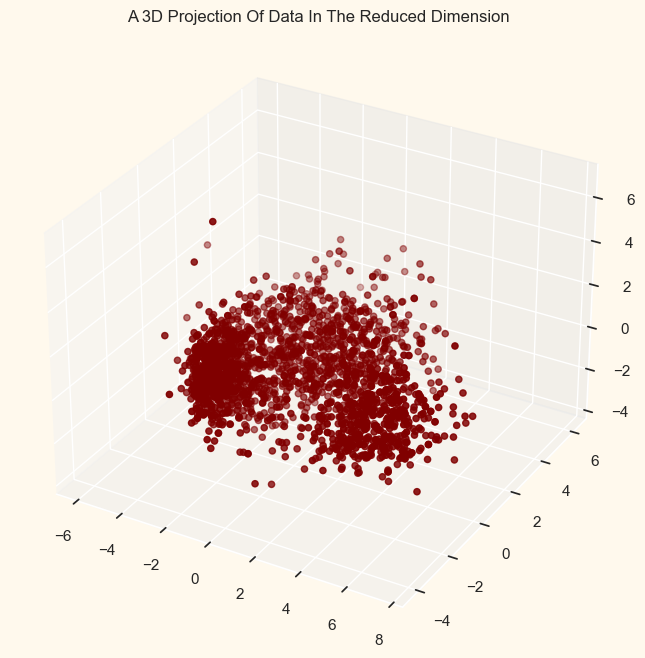

<Figure size 800x550 with 0 Axes>

In [19]:
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()
# Set the title
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
# Save the 3D scatter plot to a file
plt.savefig("3D_scatter_plot.png", dpi=300, bbox_inches='tight')

In [20]:
from sklearn.decomposition import PCA

# Set number of components to retain 90% of variance
pca = PCA(n_components=0.90)  # Retains enough components to explain 90% of the variance
pca.fit(scaled_ds)

# Check the number of components chosen
print(f"Number of components selected to retain 90% variance: {pca.n_components_}")
PCA_ds = pd.DataFrame(pca.transform(scaled_ds))
PCA_ds.describe().T

Number of components selected to retain 90% variance: 13


count          mean       std       min       25%       50%       75%  \
0   2212.0  1.284887e-17  2.878602 -5.978124 -2.539470 -0.781595  2.386380   
1   2212.0 -4.497106e-17  1.709469 -4.194757 -1.323929 -0.173721  1.234851   
2   2212.0  6.022910e-17  1.231687 -3.625248 -0.853713 -0.050842  0.863974   
3   2212.0  4.818328e-18  1.147354 -3.127582 -0.758827 -0.012351  0.888047   
4   2212.0 -4.818328e-18  1.049908 -2.975186 -0.735901  0.004181  0.704436   
5   2212.0  7.829783e-17  1.002832 -2.242013 -0.819061  0.014087  0.815724   
6   2212.0  6.103215e-17  0.975481 -3.097194 -0.693124 -0.040234  0.636987   
7   2212.0  4.175884e-17  0.915677 -4.299743 -0.515722  0.050230  0.546305   
8   2212.0  2.569775e-17  0.874972 -5.466816 -0.551387 -0.012450  0.546636   
9   2212.0  2.248553e-17  0.803261 -2.680065 -0.439647 -0.051869  0.367347   
10  2212.0  3.131913e-17  0.777093 -2.640565 -0.488181 -0.015463  0.476030   
11  2212.0 -4.075502e-17  0.743719 -2.880531 -0.438138 -0.027027  0.441142   
12  2212.0 -1.646262e-17  0.670310 -2.552445 -0.330693 -0.010880  0.330698   

         max  
0   7.452915  
1   6.168189  
2   6.750458  
3   3.403542  
4   3.103334  
5   2.421065  
6   3.521866  
7   4.981472  
8   6.141261  
9   6.012829  
10  5.330480  
11  6.293832  
12  4.904918

Elbow Method to determine the number of clusters to be formed:


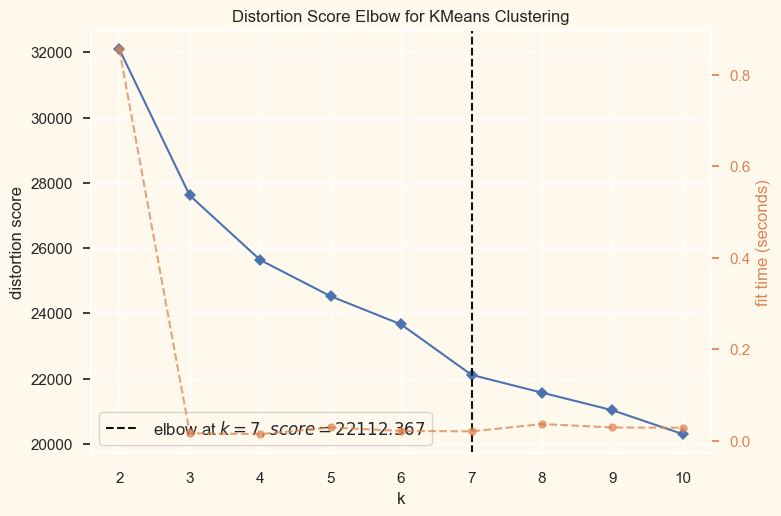

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [21]:
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
# Save the Elbow plot to a file
Elbow_M.show(outpath="elbow_method_plot.png")
Elbow_M.show()

In [22]:
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

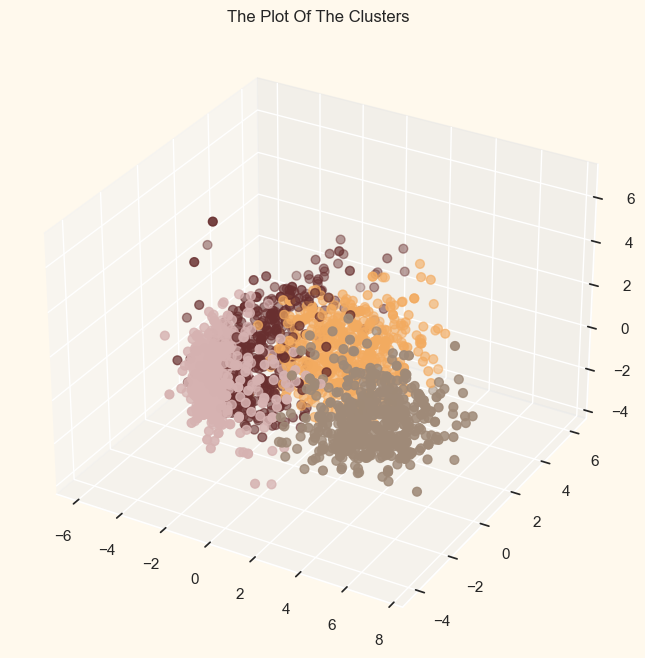

In [23]:
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
# Save the 3D scatter plot to a file
plt.savefig("3D_clusters_plot.png", dpi=300, bbox_inches='tight')
plt.show()

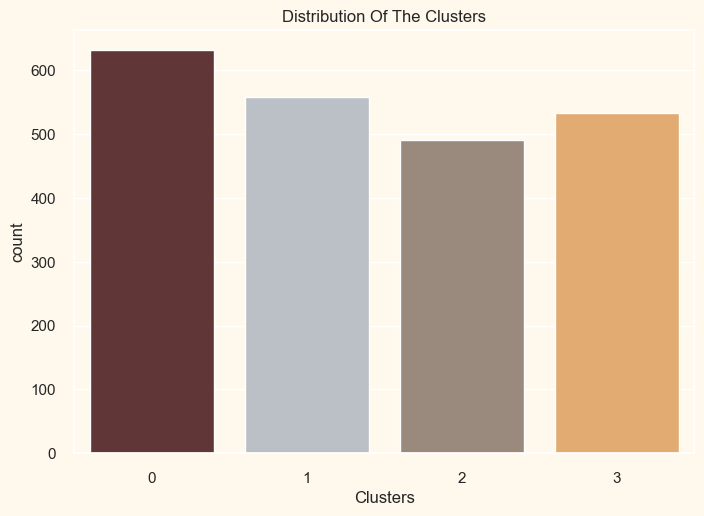

In [24]:
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
# Save the plot to a file
plt.savefig("cluster_distribution_plot.png", dpi=300, bbox_inches='tight')
plt.show()

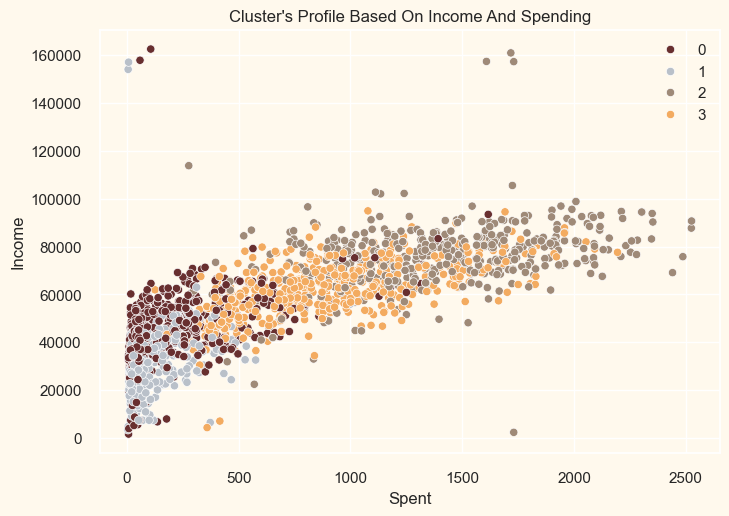

In [25]:
pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
# Save the plot to a file
plt.savefig("cluster_profile_plot.png", dpi=300, bbox_inches='tight')
plt.show()

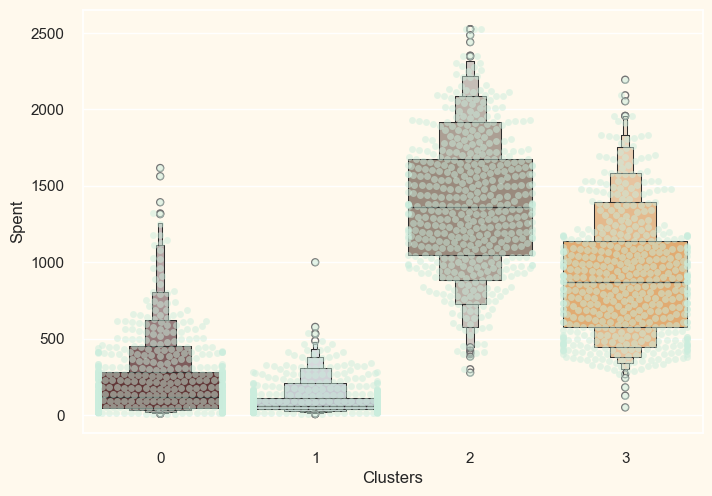

In [26]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
# Save the plot to a file
plt.savefig("swarmboxen_plot.png", dpi=300, bbox_inches='tight')
plt.show()

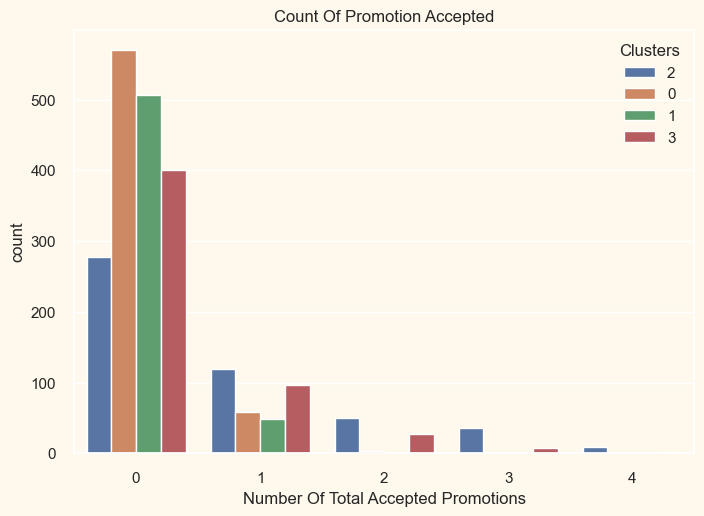

In [27]:
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
data["Clusters"] = data["Clusters"].astype(str)
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"])
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
# Save the plot to a file
plt.savefig("promotion_accepted_countplot.png", dpi=300, bbox_inches='tight')
plt.show()

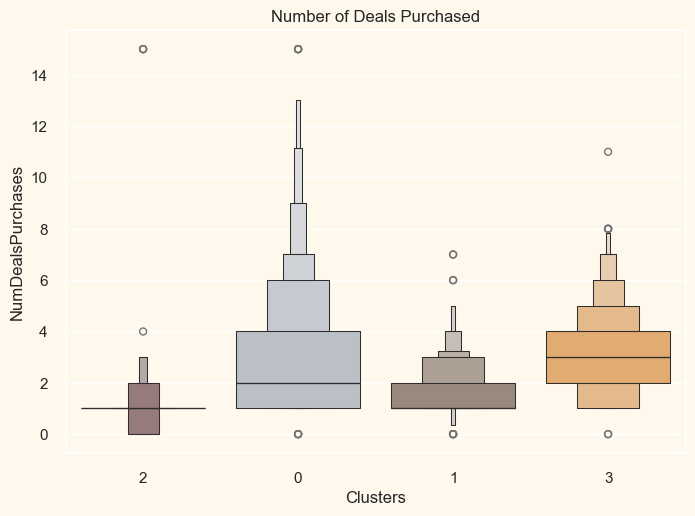

In [28]:
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
# Save the plot to a file
plt.savefig("deals_purchased_boxenplot.png", dpi=300, bbox_inches='tight')
plt.show()

<Figure size 800x550 with 0 Axes>

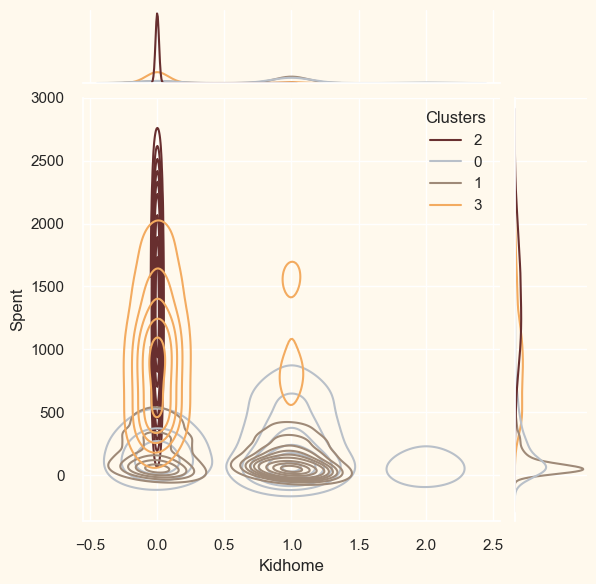

<Figure size 800x550 with 0 Axes>

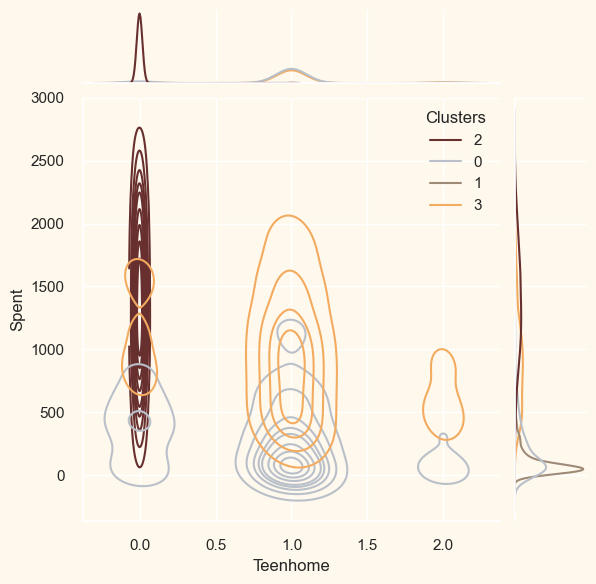

<Figure size 800x550 with 0 Axes>

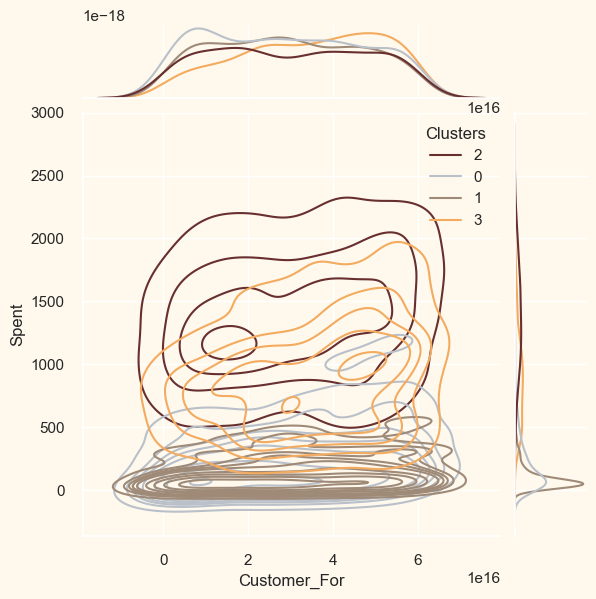

<Figure size 800x550 with 0 Axes>

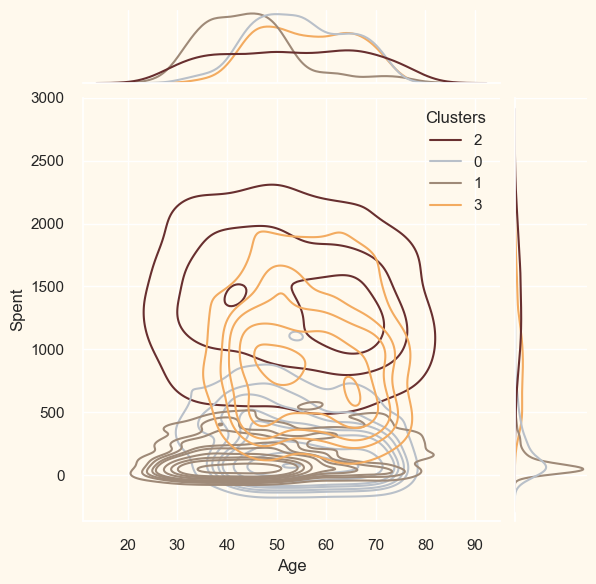

<Figure size 800x550 with 0 Axes>

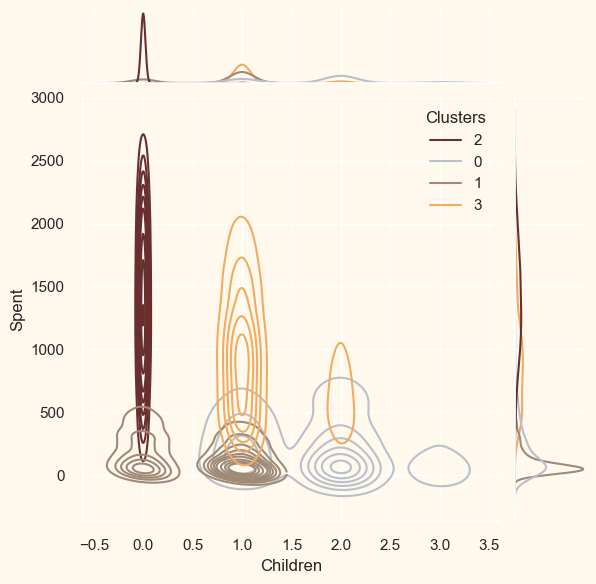

<Figure size 800x550 with 0 Axes>

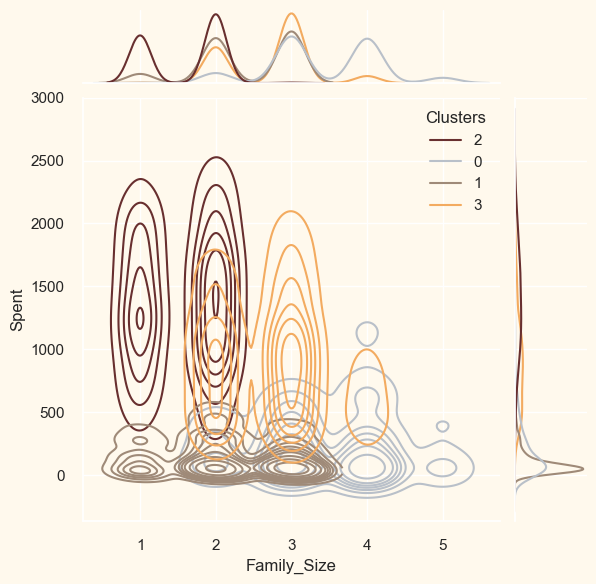

<Figure size 800x550 with 0 Axes>

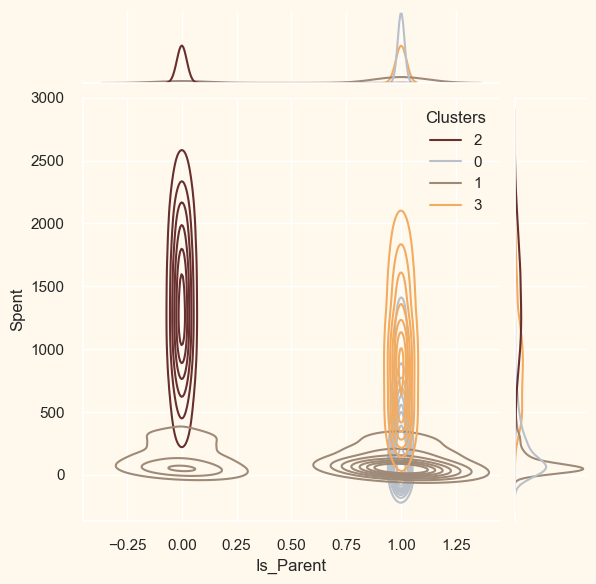

<Figure size 800x550 with 0 Axes>

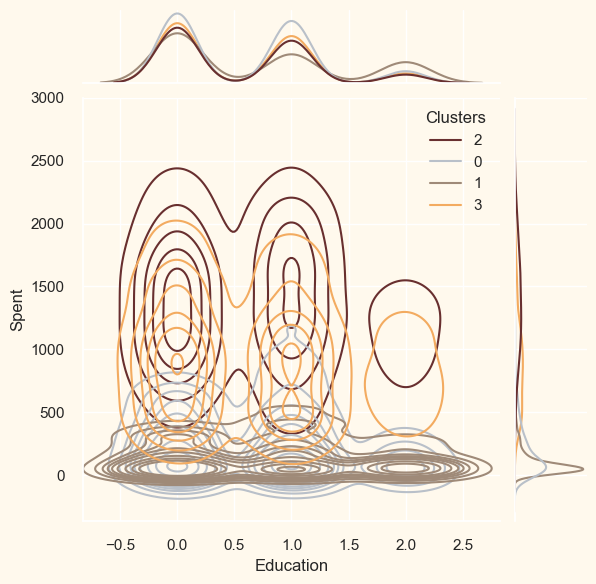

<Figure size 800x550 with 0 Axes>

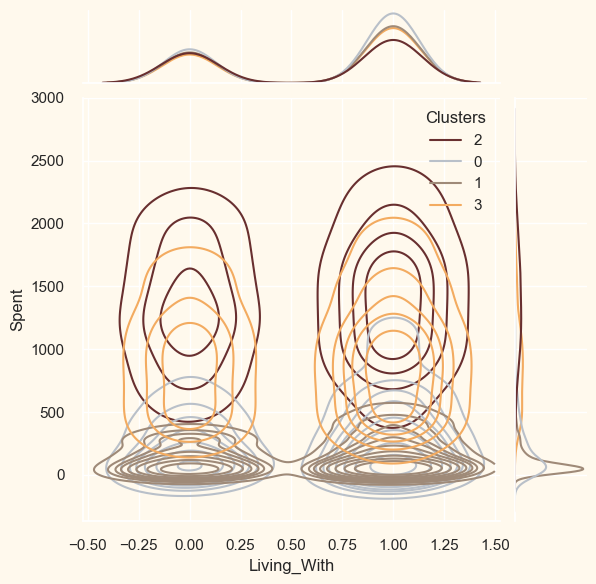

In [29]:
Personal = [ "Kidhome","Teenhome","Customer_For", "Age", "Children", "Family_Size", "Is_Parent", "Education","Living_With"]

for i in Personal:
    plt.figure()
    sns.jointplot(x=data[i], y=data["Spent"], hue =data["Clusters"], kind="kde", palette=pal)
    plt.savefig(f"jointplot_{i}_vs_Spent.png", dpi=300, bbox_inches='tight')
    plt.show()

In [30]:
# Cluster properties on the unscaled data
cluster_unscaled_centers = data.groupby("Clusters").mean()

# Summarizing key attributes for unscaled data
summary_unscaled = data.groupby("Clusters").agg({
    'Spent': ['mean', 'median', 'min', 'max'],
    'Income': ['mean', 'median', 'min', 'max'],
    'Age': ['mean', 'median', 'min', 'max'],
    'Family_Size': ['mean', 'median', 'min', 'max']
})

print("\nUnscaled Cluster Summary of Key Attributes:")
print(summary_unscaled)



Unscaled Cluster Summary of Key Attributes:
                Spent                           Income                   \
                 mean  median  min   max          mean   median     min   
Clusters                                                                  
0          212.532488   114.0    8  1616  44219.893819  43783.0  1730.0   
1           98.436266    61.0    5   999  29844.649910  29187.0  3502.0   
2         1376.898167  1364.0  277  2525  75878.044807  76412.0  2447.0   
3          897.341463   868.0   49  2194  62196.146341  62466.0  4428.0   

                          Age                Family_Size                 
               max       mean median min max        mean median min max  
Clusters                                                                 
0         162397.0  54.879556   54.0  30  75    3.415214    3.0   1   5  
1         156924.0  44.486535   43.0  25  81    2.402154    2.0   1   3  
2         160803.0  52.896130   52.0  26  80    1.596741   

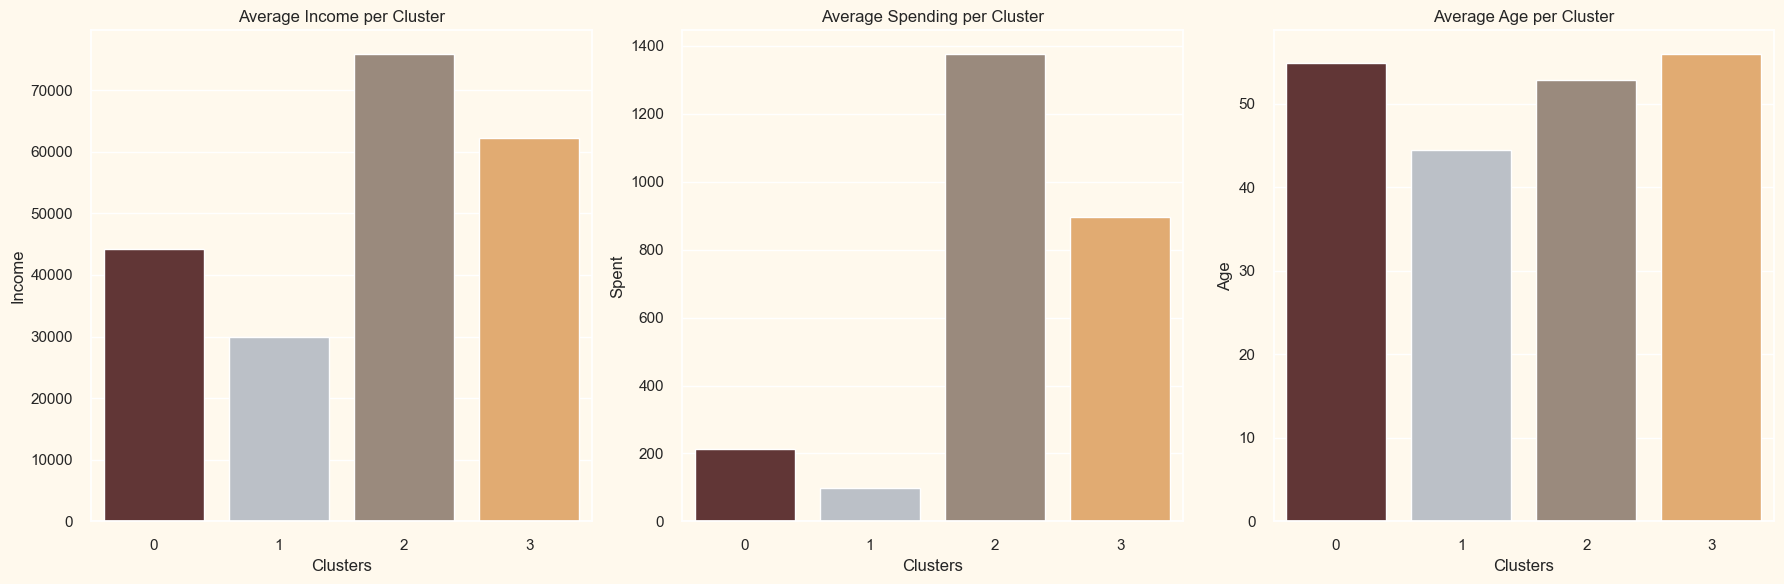

In [31]:
# Average Income, Spending, and Age for each cluster
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plotting average income
sns.barplot(x=cluster_unscaled_centers.index, y=cluster_unscaled_centers['Income'], palette=pal, ax=axes[0])
axes[0].set_title("Average Income per Cluster")
axes[0].set_ylabel("Income")

# Plotting average spending
sns.barplot(x=cluster_unscaled_centers.index, y=cluster_unscaled_centers['Spent'], palette=pal, ax=axes[1])
axes[1].set_title("Average Spending per Cluster")
axes[1].set_ylabel("Spent")

# Plotting average age
sns.barplot(x=cluster_unscaled_centers.index, y=cluster_unscaled_centers['Age'], palette=pal, ax=axes[2])
axes[2].set_title("Average Age per Cluster")
axes[2].set_ylabel("Age")
# Save the plot to a file
plt.savefig("average_metrics_per_cluster.png", dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()


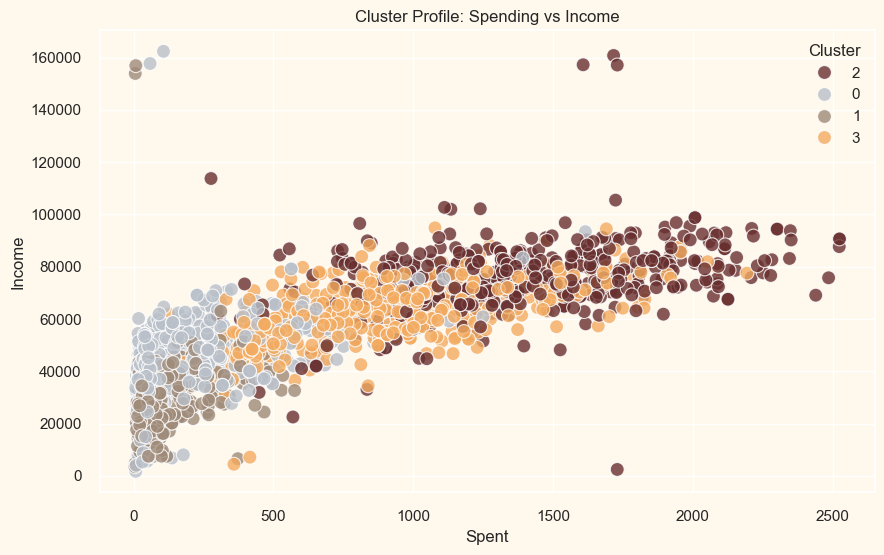

In [32]:
# Scatter plot of Spending vs. Income colored by Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=data["Spent"], y=data["Income"], hue=data["Clusters"], palette=pal, s=100, alpha=0.8)
plt.title("Cluster Profile: Spending vs Income")
plt.xlabel("Spent")
plt.ylabel("Income")
plt.legend(title="Cluster")
# Save the plot to a file
plt.savefig("scatterplot_spending_vs_income.png", dpi=300, bbox_inches='tight')
plt.show()


In [33]:
# Function to name clusters based on data insights
def name_clusters(cluster_centers_unscaled):
    cluster_names = []
    cnt=0
    
    for i, row in cluster_centers_unscaled.iterrows():
        cluster_names.append([])
        if row['Spent'] > 600 and row['Income'] > 5000:
            cluster_names[cnt].append("High-Spender, Wealthy")
        if row['Spent'] < 500 and row['Income'] < 30000:
            cluster_names[cnt].append(" Low-Spender, Low-Income")
        if row['Is_Parent'] > 0.5 and row['Family_Size'] > 3:
            cluster_names[cnt].append(" Family_Oriented, Moderate Spender")
        if row['Is_Parent']>0.9 :
            cluster_names[cnt].append(" Has Many Chidren")
        
        
        cnt+=1
    
    return cluster_names

# Name clusters based on their representative points (unscaled data)
cluster_names = name_clusters(cluster_unscaled_centers)
print("\nCluster Names for Stakeholders:")
for name in cluster_names:
    print(name)



Cluster Names for Stakeholders:
[' Family_Oriented, Moderate Spender', ' Has Many Chidren']
[' Low-Spender, Low-Income']
['High-Spender, Wealthy']
['High-Spender, Wealthy', ' Has Many Chidren']


In [34]:
cluster_unscaled_centers

Education        Income   Kidhome  Teenhome    Recency       Wines  \
Clusters                                                                       
0          0.597464  44219.893819  0.809826  0.931854  48.939778  120.592710   
1          0.709156  29844.649910  0.752244  0.000000  48.888689   31.947935   
2          0.558045  75878.044807  0.002037  0.004073  49.128310  609.798371   
3          0.568480  62196.146341  0.086304  0.992495  49.150094  529.073171   

             Fruits        Meat       Fish     Sweets  ...  Complain  \
Clusters                                               ...             
0          6.575277   46.215531   9.576862   7.011094  ...  0.009509   
1          7.023339   25.301616  10.576302   6.847397  ...  0.010772   
2         63.378819  473.195519  92.354379  64.224033  ...  0.006110   
3         35.761726  176.127580  48.778612  37.626642  ...  0.009381   

          Response  Customer_For        Age        Spent  Living_With  \
Clusters                                                                
0         0.080824  2.854760e+16  54.879556   212.532488     0.673534   
1         0.118492  2.943991e+16  44.486535    98.436266     0.649910   
2         0.313646  2.993698e+16  52.896130  1376.898167     0.590631   
3         0.116323  3.469065e+16  55.975610   897.341463     0.658537   

          Children  Family_Size  Is_Parent  Total_Promos  
Clusters                                                  
0         1.741680     3.415214   0.996830      0.101426  
1         0.752244     2.402154   0.752244      0.091562  
2         0.006110     1.596741   0.006110      0.739308  
3         1.078799     2.737336   0.992495      0.341463  

[4 rows x 31 columns]

In [35]:
# Define all required features
all_features = ['Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines', 'Fruits', 'Meat',
                'Fish', 'Sweets', 'Gold', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
                'NumStorePurchases', 'NumWebVisitsMonth', 'Customer_For', 'Age', 'Spent', 'Living_With',
                'Children', 'Family_Size', 'Is_Parent']

# Example new customer data
new_customer = pd.DataFrame({
    'Education': [2],  # Assuming Education levels are encoded (e.g., 0: Basic, 1: Graduate, 2: Postgraduate)
    'Income': [50000],
    'Kidhome': [0],
    'Teenhome': [0],
    'Recency': [20],
    'Wines': [200],
    'Fruits': [50],
    'Meat': [100],
    'Fish': [30],
    'Sweets': [60],
    'Gold': [40],
    'NumDealsPurchases': [2],
    'NumWebPurchases': [5],
    'NumCatalogPurchases': [1],
    'NumStorePurchases': [3],
    'NumWebVisitsMonth': [10],
    'Customer_For': [365],
    'Age': [30],
    'Spent': [500],
    'Living_With': [2],  # Assuming Living_With is encoded (e.g., 1: Alone, 2: Partner)
    'Children': [0],
    'Family_Size': [2],
    'Is_Parent': [0]
})

# Ensure the DataFrame has the correct order of columns
new_customer = new_customer[all_features]


In [36]:
from sklearn.neighbors import NearestCentroid

def classify_new_customer(new_data, clustering_model, scaler, scaled_ds):
    # Fit the NearestCentroid classifier on the scaled data and clusters
    nc = NearestCentroid()
    nc.fit(scaled_ds, clustering_model.labels_)
    
    # Scale the new data with the same scaler used previously
    new_data_scaled = scaler.transform(new_data)
    
    # Predict the cluster for the new customer
    cluster = nc.predict(new_data_scaled)
    return cluster

# Classify the new customer
new_customer_cluster = classify_new_customer(new_customer, AC, scaler, scaled_ds)
print("New customer classified into Cluster:", new_customer_cluster[0])


New customer classified into Cluster: 1


In [37]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = np.cumsum(explained_variance_ratio)
cumulative_explained_variance

array([0.36011321, 0.48711165, 0.5530406 , 0.61025046, 0.65815522,
       0.70186034, 0.74321393, 0.77965241, 0.81292328, 0.84096401,
       0.86720754, 0.89124526, 0.91077189])

In [38]:
# For example, to see the percentage of variance retained by the first 3 components
num_components = 13
percentage_retained = cumulative_explained_variance[num_components - 1] * 100
print(f"Percentage of information retained by the first {num_components} components: {percentage_retained:.2f}%")


Percentage of information retained by the first 13 components: 91.08%


In [39]:
import joblib 

In [40]:
joblib.dump(pca,"pcamodel.pkl")

['pcamodel.pkl']

In [41]:
cluster_centers_unscaled.iterrows()

NameError: name 'cluster_centers_unscaled' is not defined

In [ ]:
for i, row in cluster_unscaled_centers.iterrows():
    print(i)

In [43]:
PCA_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2212 entries, 0 to 2211
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   0         2212 non-null   float64
 1   1         2212 non-null   float64
 2   2         2212 non-null   float64
 3   3         2212 non-null   float64
 4   4         2212 non-null   float64
 5   5         2212 non-null   float64
 6   6         2212 non-null   float64
 7   7         2212 non-null   float64
 8   8         2212 non-null   float64
 9   9         2212 non-null   float64
 10  10        2212 non-null   float64
 11  11        2212 non-null   float64
 12  12        2212 non-null   float64
 13  Clusters  2212 non-null   int64  
dtypes: float64(13), int64(1)
memory usage: 242.1 KB
